In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp

from overall_posterior import OverallPosterior

# Get Overall Posterior
## $P(\theta|X_{1},...X_{n}) = $${{P(\theta)}^{1-n}\Pi_{i}[P(\theta|X_{i})]} \over {\int{{P(\theta)}^{1-n}}\Pi_{i}[P(\theta|X_{i})]d\theta}$

In [2]:
# Prior doesn't have to be identical to network's prior
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
n_eval = 300
epsilon = -150
log_Cs = pd.read_csv('posteriors/log_Cs.csv', index_col=0)
sample_df = pd.read_csv('maps/overall_posterior_samples.csv', index_col=0) #pre-saved samples

overall_posteriors = {}

lines = ['wt', 'ltr', 'ars', 'all']
for line in lines:
    amortized_posterior = posterior_lauer if line=='lauer' else posterior_chuong
    Xs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0)
    log_C = float(log_Cs.loc[line,str(epsilon)])
    op = OverallPosterior(prior, amortized_posterior, Xs, n_eval, log_C, epsilon)
    samples = sample_df[sample_df['line']==line].iloc[:,1:] # only parameter values
    op.samples = torch.tensor(np.array(samples,dtype='float64')).reshape(len(samples),3)
    overall_posteriors[line] = op
    
rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
label_dict = {'wt': 'Wild type architecture', 'ltr': 'LTRs removed', 'ars': 'ARS removed', 'all': 'LTR and ARS removed', 'lauer': 'Lauer'}

# Get MAPs (Maximum A-Posteriori)

In [3]:
for line in lines:
    print(f'{line} MAP: {list(overall_posteriors[line].get_map())}')

wt MAP: [-0.7381819886402883, -4.344689363776233, -3.772640940870402]
ltr MAP: [-0.7376684262382086, -4.83598162781289, -4.316417704832799]
ars MAP: [-0.840286513785892, -5.617070644141457, -5.388356156715897]
all MAP: [-0.899681749694911, -5.049764505315668, -5.218884049384233]


# Marginal Posteriors

In [21]:
import matplotlib as mpl

label_size = 6
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = 10

def plotline(line):
        op = overall_posteriors[line]
        op.plot_pairwise(color=rep_colors[line])    
        plt.show()

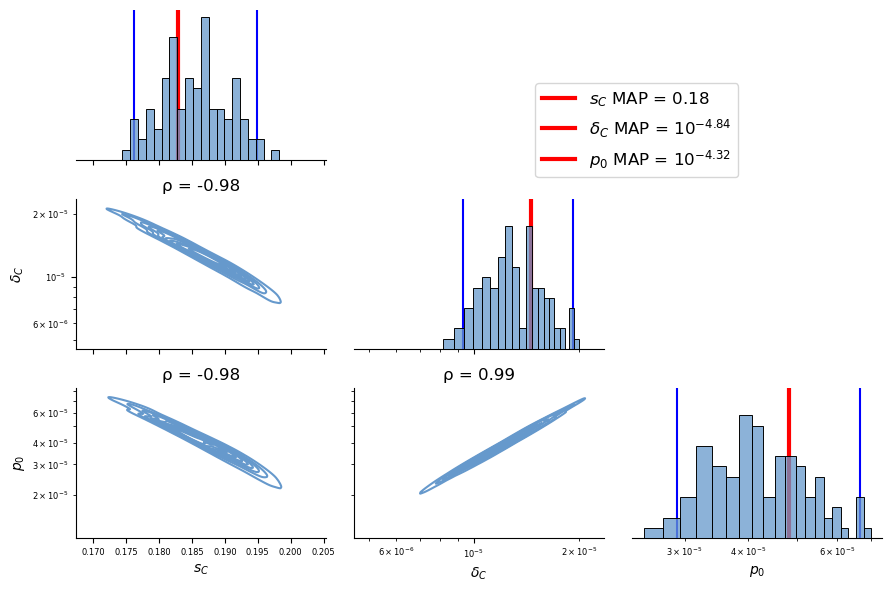

In [23]:
plotline('ltr')

# Overall Posterior Validation

## Predictive Checks - Simulate Overall Posterior MAP and compare to empirical observations

(-0.05, 1.05)

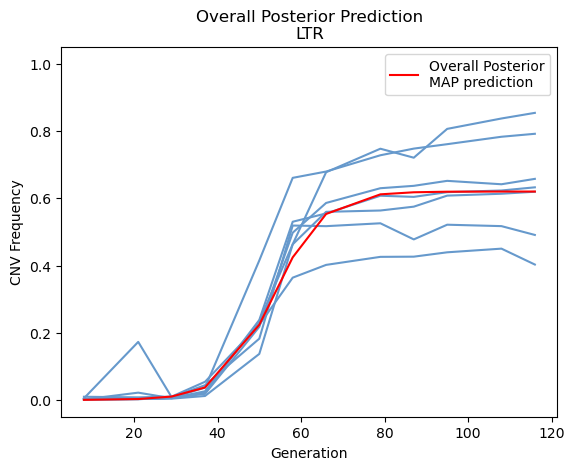

In [20]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF

# Model (simulator)
reps = 1
generation = pd.read_csv('Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 3.3e8

def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
    return states

line = 'ltr'
op = overall_posteriors[line]
for i in range(len(op.Xs)):
    plt.plot(generation.tolist(),op.Xs.iloc[i,:], color=rep_colors[line])

# Overall MAP
overall_map = op.map
params = torch.tensor(list(overall_map), dtype=torch.float64)
x = CNVsimulator(params).T
plt.plot(generation.tolist(),x, label = 'Overall Posterior\nMAP prediction', color='red')

# Plotting
plt.legend()
# plt.title('Overall Posterior Prediction\nLTR+ARS (all) KO')
plt.title(f'Overall Posterior Prediction\n{line.upper()}')

plt.xlabel('Generation')
plt.ylabel('CNV Frequency')
# plt.title(f'log(s) = {float(params[0])}, log(δ) = {float(params[1])}')
plt.ylim(-0.05,1.05)

# Sensitivity to $\epsilon$

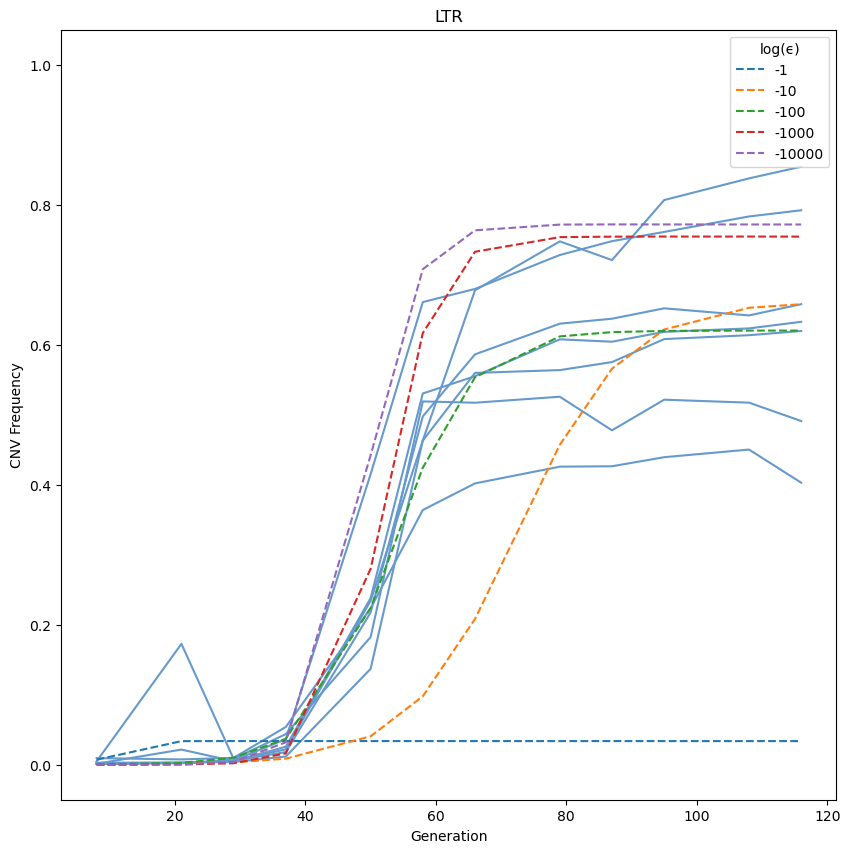

In [22]:
def plot_epsilons(ax, line, epsilons):
# Plot Overall Posterior prediction for WT
# Get data
    op = overall_posteriors[line]
    for i in range(len(op.Xs)):
        ax.plot(generation.tolist(),op.Xs.iloc[i,:], color=rep_colors[line])

    # Overall MAP
    for ϵ in epsilons:
        opp = OverallPosterior(op.prior, op.amortized_posterior, Xs=op.Xs, n_eval=100, log_C=1, epsilon=ϵ)
        opp.get_log_C()
        overall_map = opp.get_map()
        params = torch.tensor(list(overall_map), dtype=torch.float64)
        x = CNVsimulator(params).T
        ax.plot(generation.tolist(),x, label = ϵ, linestyle='--')

    # Plotting
    ax.legend(title = 'log(ϵ)')
    ax.set_title(f'{line.upper()}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('CNV Frequency')
    ax.set_ylim(-0.05,1.05)

fig, ax = plt.subplots(figsize=(10,10))
epsilons=[-1,-10,-100,-1000, -10000]
plot_epsilons(ax, 'ltr', epsilons)

## All lines (around $\epsilon=100$)

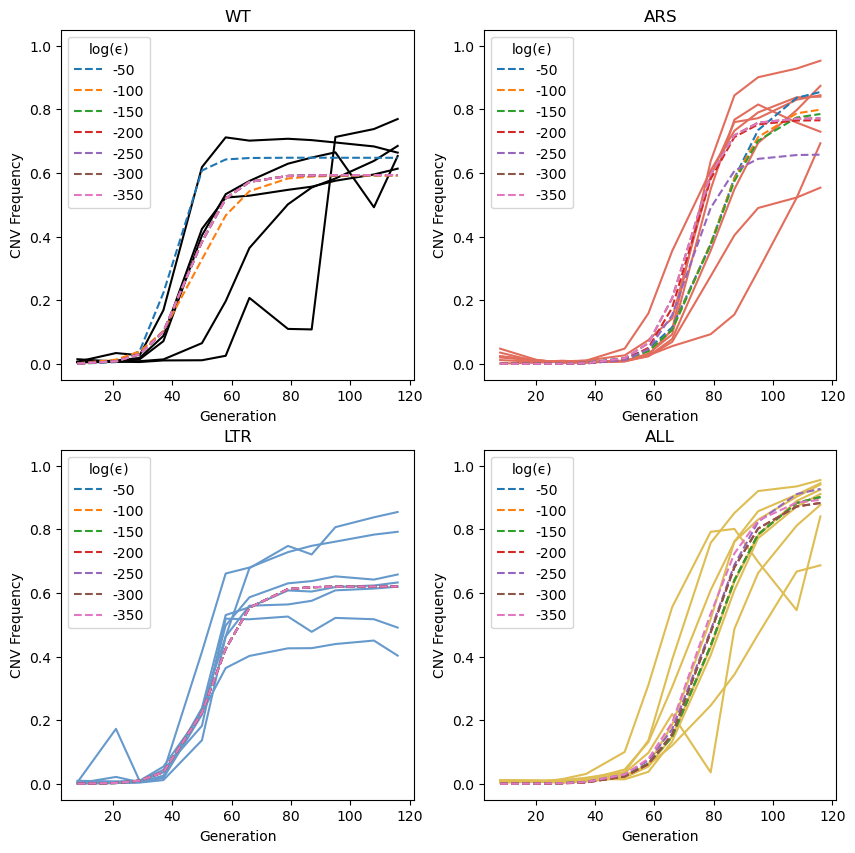

In [23]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
epsilons = [-50,-100,-150,-200,-250,-300, -350]
plot_epsilons(ax[0,0], 'wt', epsilons)
plot_epsilons(ax[1,0], 'ltr', epsilons)
plot_epsilons(ax[0,1], 'ars', epsilons)
plot_epsilons(ax[1,1], 'all', epsilons)
plt.show()

# MAPs and samples

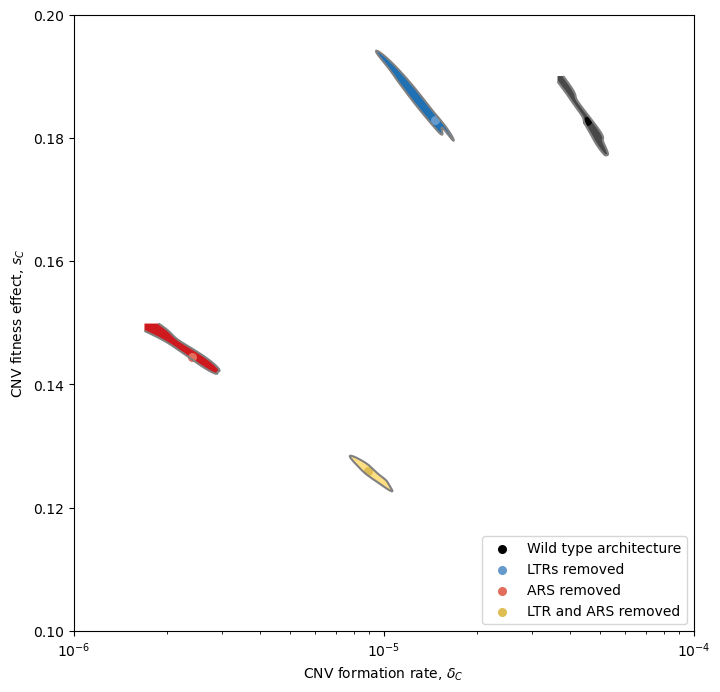

In [7]:
from seaborn import scatterplot, kdeplot
import arviz as az
import matplotlib as mpl

label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = label_size


# Plot formation rate δc and fitness effect Sc for given MAPs
def plot_maps(ax, lines, title):
    rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
    for line in lines: 
        knock = ' knockout' if line!='wt' else ''
        op = overall_posteriors[line]
        mapp = op.map
        x, y = 10**mapp[1], 10**mapp[0]
        
        
        # Add samples
        samples = op.samples
        xdf, ydf = 10**samples[:,1], 10**samples[:,0]
        xmin,xmax = xdf.min(), xdf.max()
        ymin,ymax = ydf.min(), ydf.max()
        
        # Bars
        # ax.vlines(x, ymin=ymin,ymax=ymax,color=rep_colors[line])
        # ax.hlines(y,xmin=xmin,xmax=xmax,color=rep_colors[line])
        
        # HDI
        colors =  {'wt':"Greys", 'ltr':"Blues", 'ars': "Reds", 'all':"YlOrRd_r"}
        a = az.plot_kde(
            xdf,
            ydf,
            hdi_probs=[0.5],
                    ax=ax, contourf_kwargs = {'cmap':colors[line]}
                        )
        ax.scatter(x, y, color=rep_colors[line], s = 30, label = label_dict[line])
        ax.set_xlabel('CNV formation rate, $δ_C$')
        ax.set_ylabel('CNV fitness effect, $s_C$')
        ax.set_title(title)
        ax.set_xscale('log')
        ax.legend(loc='lower right')

    
fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylim(0.1,0.2)
ax.set_xlim(10**-6, 10**-4)
        
# Only Chuong

chuong_lines = ['wt', 'ltr', 'ars', 'all']
plot_maps(ax, chuong_lines, '')
plt.show()